In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os



In [4]:
import nwatides
from nwatides.hanalysis import least_square
from nwatides.hamcmcjax import *
from nwatides import scoring
import nwatides.nonstat_itides_jax as nsjax

In [5]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='medium'
plt.rcParams['pcolor.shading']='auto'

In [124]:
site='Broome'
ylims = (-5,5)

site='Hillarys'
ylims = (-1,1)


t1,t2 = '2000-01-01 00:00:00', '2002-01-01 00:00:00'
dsall = xr.open_dataset(f'../DATA/TIDES/{site}Tides_19922022.nc')
ds = dsall.sel(time=slice(t1,t2))

ds['waterlevel']=ds['waterlevel'].where(ds['waterlevel']>-999, np.nan)
eta = ds['waterlevel'] - ds['waterlevel'].mean()

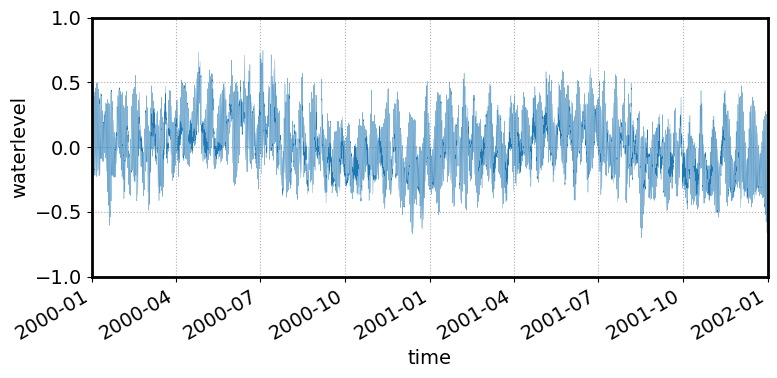

In [125]:
plt.figure(figsize=(8,4))

eta.plot(lw=0.2)
plt.title('')
plt.ylim(ylims)
plt.title('')
plt.xlim(eta.time[0], eta.time[-1])
plt.grid(True, ls=':')
plt.tight_layout()
plt.savefig(f'../FIGURES/waterlevel_{site}_raw.png',dpi=150)

In [126]:
# constituents = ['m2','s2','k1','o1']
constituents = None
# constituents = ['m2','s2','n2','k2','k1','o1','p1','q1']


idx=~np.isnan(eta.values)
y = eta.values[idx]
t = eta.time.values[idx]

ar = nwatides.get_tidal_arguments(t)
if constituents is None:
    constituents=ar.constituents.values

ha = least_square(y, t, constituents)
ha

<xarray.Dataset>
Dimensions:      (c: 34, time: 17545)
Coordinates:
  * c            (c) object '2n2' 'eps2' 'j1' 'k1' 'k2' ... 's4' 'sa' 'ssa' 't2'
  * time         (time) datetime64[ns] 2000-01-01 ... 2002-01-01
Data variables:
    h_real       (c) float64 0.0007692 0.0007221 -0.008103 ... -0.02475 0.0017
    h_imag       (c) float64 -0.003712 -0.001798 ... -0.003945 -0.002718
    h_real_var   (c) float64 1.493e-06 1.481e-06 ... 1.511e-06 1.511e-06
    h_imag_var   (c) float64 1.493e-06 1.481e-06 ... 1.512e-06 1.512e-06
    h            (time) float64 -0.07977 -0.05277 -0.01077 ... -0.6688 -0.6428
    h_predicted  (time) float64 -0.1939 -0.1759 -0.1452 ... -0.4275 -0.4164
    h_residual   (time) float64 0.1141 0.1231 0.1344 ... -0.2154 -0.2413 -0.2264

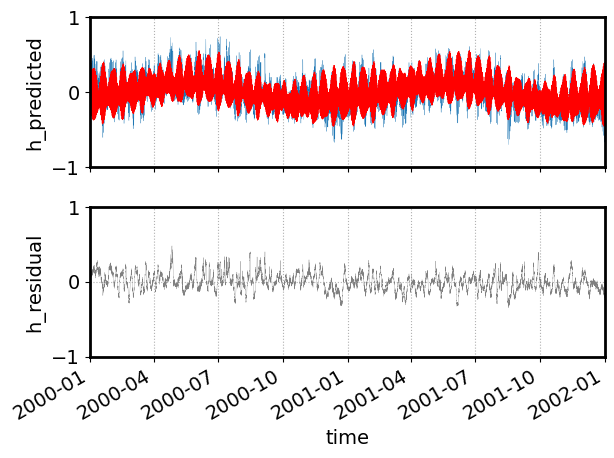

In [127]:
plt.figure()
ax=plt.subplot(211)
ha['h'].plot(lw=0.2)
ha['h_predicted'].plot(c='r',lw=0.4)
plt.title('')
plt.ylim(ylims)
plt.title('')
plt.xlim(eta.time[0], eta.time[-1])
plt.grid(True, ls=':')
ax.set_xticklabels([])
ax.set_xlabel('')

ax=plt.subplot(212)
ha['h_residual'].plot(c='0.5',lw=0.2)
# ha['h_predicted'].plot(c='k',lw=0.4)
plt.title('')
plt.ylim(ylims)
plt.title('')
plt.xlim(eta.time[0], eta.time[-1])
plt.grid(True, ls=':')
# ax.set_xticklabels([])
# ax.set_xlabel('')


plt.tight_layout()
plt.savefig(f'../FIGURES/waterlevel_{site}_harmonic_residual.png',dpi=150)

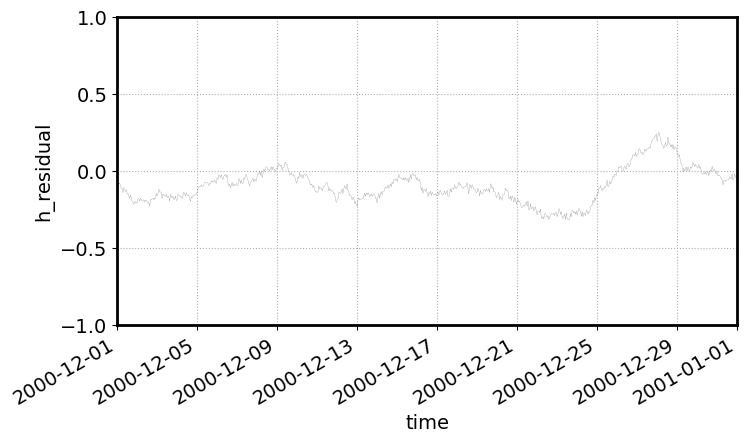

In [66]:
plt.figure(figsize=(8,4))
ha['h_residual'].plot(c='0.5', lw=0.2)
# ha['h_predicted'].plot(c='k',lw=0.4)
plt.title('')
plt.ylim(ylims)
plt.title('')
plt.xlim(onp.datetime64('2000-12-01'),onp.datetime64('2001-01-01'))
plt.grid(True, ls=':')
plt.savefig(f'../FIGURES/waterlevel_{site}_harmonic_residual_zoom.png',dpi=150)

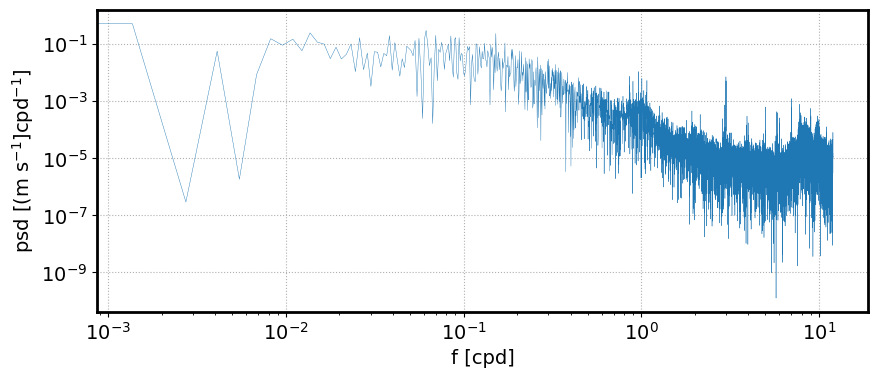

In [67]:
# Speccy the residual
X=t.astype(float)/1e9/86400. # Days

dt = X[1]-X[0]
# y = ha['h_residual']

f, I = nsjax.periodogram(ha['h'].values, dt)
f, I2 = nsjax.periodogram(ha['h_residual'].values, dt)

# acf = covfunc(X, X[0], params[ii,:].values, **cov_kwargs)
# f_S, S = nsjax.bochner(acf, delta=dt)

plt.figure(figsize=(9,4))
# ax1=plt.subplot(121)
# plt.loglog(f, 2*I)
plt.loglog(f, 2*I2, lw=0.3)

# plt.loglog(f_S,S)
# plt.loglog(f_S,Si,':')
# plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')
plt.ylabel('psd [(m s$^{-1}$]cpd$^{-1}$]')
plt.grid(True, ls=':')
plt.tight_layout()
plt.savefig(f'../FIGURES/waterlevel_{site}_psd.png',dpi=150)

In [94]:
fmin = 1e-2 #0.7

# covfunc=nsjax.itide_meso_nof_gammaexp
# covlabels = ['η_m','τ_m','γ_m','η_D2','τ_D2','η_D1','τ_D1']
# covparams = (0.1, 7, 1.5, 0.01, 7, 0.01, 7)

covfunc=nsjax.itide_fD2D1_meso_gammaexp
covfunc_gp = itide_fD2D1_meso_gammaexp_t
covparams = (0.1, 7, 1.5, 0.01, 7, 0.01, 7, 0.01, 7)
covlabels = ['η_m','τ_m','γ_m','η_f','τ_f','η_D2','τ_D2','η_D1','τ_D1']
fmax = 2.5 #

# covfunc=nsjax.meso_D2_periodic
# covfunc_gp = nsjax.meso_D2_periodic_t

# covparams = (0.01, 7, 1.0, 0.01, 2., 0.5, 0.1, 0.1, 7.)
# covlabels = ['η_m','τ_m','γ_m','η_iw','τ_iw','γ_iw','η_D2','l_D2','τ_D2']
# fmax = 10 #


In [95]:
import optax

In [96]:
%%time
params, loss_val = nsjax.estimate_jax(ha['h_residual'].values, X,
                     covfunc, covparams, fmin, fmax,
                      maxiter=5000,
                     opt= optax.adabelief(learning_rate=1e-2),
                     #opt= optax.sgd(learning_rate=3e-4),
                    #transformer=LogTransformer,
                     verbose=True)

step 0, loss: -18625.384957479284
[0.10100502 6.93034884 1.48507475 0.0101005  6.93034884 0.0101005
 6.93034884 0.0101005  6.93034884]
step 25, loss: -28315.79068837964
[0.12904944 5.46606951 1.19789957 0.01229395 5.58657201 0.01011505
 6.31725054 0.01255661 5.50985028]
step 50, loss: -28514.867646111365
[0.13575052 5.20004485 1.17656284 0.01225851 5.26266205 0.00744344
 7.23615082 0.01304135 5.11989328]
step 75, loss: -28703.27861007194
[1.35017903e-01 5.19395680e+00 1.21592908e+00 1.16838093e-02
 5.09030054e+00 5.49673136e-03 8.13988221e+00 1.30004842e-02
 4.88796870e+00]
step 100, loss: -28815.361928460552
[1.36760320e-01 5.10233674e+00 1.24787853e+00 1.12041873e-02
 4.87512315e+00 4.28181622e-03 8.70740156e+00 1.30703383e-02
 4.58829201e+00]
step 125, loss: -28899.25389956031
[1.40038374e-01 4.95459584e+00 1.27382329e+00 1.08215173e-02
 4.63897512e+00 3.50192302e-03 8.94165041e+00 1.32023720e-02
 4.25795718e+00]
step 150, loss: -28966.668427567707
[1.43158051e-01 4.80501274e+00 1.3

In [98]:
print(''.join('{} | '.format(k) for k in covlabels))
print(''.join('{:3.4f} | '.format(k) for k in params))

η_m | τ_m | γ_m | η_f | τ_f | η_D2 | τ_D2 | η_D1 | τ_D1 | 
0.1119 | 1.7649 | 1.6363 | 0.0060 | 2.2490 | 0.0025 | 2.1483 | 0.0134 | 2.3558 | 


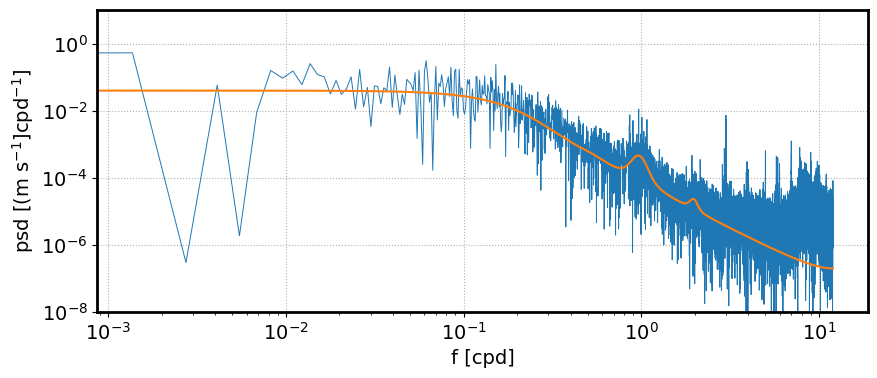

In [99]:
acf = covfunc(X, X[0], params, )
f_S, S = nsjax.bochner(acf, delta=dt, h=np.hanning(X.shape[0]))

plt.figure(figsize=(9,4))
# ax1=plt.subplot(121)
# plt.loglog(f, 2*I)
plt.loglog(f, 2*I2, lw=0.7)

plt.loglog(f_S,S)
#plt.xlim(fmin, fmax)
# plt.xlim(1, 5)
plt.xlabel('f [cpd]')
plt.grid(True, ls=':')
plt.ylim(1e-8, 1e1)
# plt.title(sites[sitenum])
plt.xlabel('f [cpd]')
plt.ylabel('psd [(m s$^{-1}$]cpd$^{-1}$]')
plt.grid(True, ls=':')
plt.tight_layout()

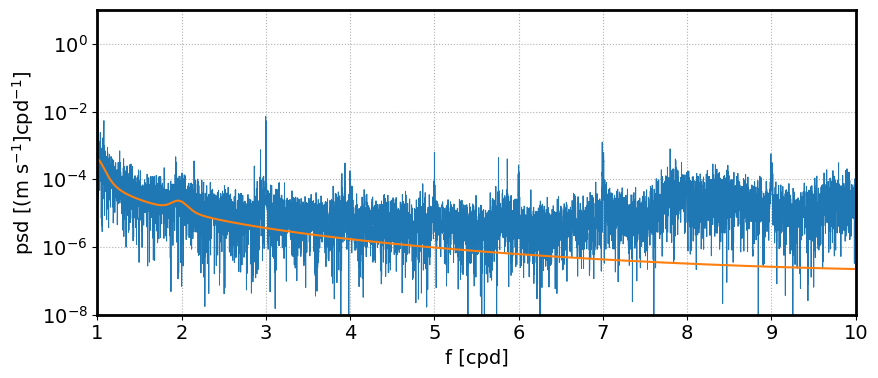

In [100]:
plt.figure(figsize=(9,4))
# ax1=plt.subplot(121)
# plt.loglog(f, 2*I)
plt.semilogy(f, 2*I2, lw=0.7)

plt.semilogy(f_S,S)
#plt.xlim(fmin, fmax)
plt.xlim(1, 10)
plt.xlabel('f [cpd]')
plt.grid(True, ls=':')
plt.ylim(1e-8, 1e1)
# plt.title(sites[sitenum])
plt.xlabel('f [cpd]')
plt.ylabel('psd [(m s$^{-1}$]cpd$^{-1}$]')
plt.grid(True, ls=':')
plt.tight_layout()

In [101]:
ds_train = dsall['waterlevel'].sel(time=slice('2022-11-01 00:00:00','2022-11-15 00:00:00')).\
    isel(time=slice(None,None,1)) # Hourly data
ds_train -= ds_train.mean()

ds_test= dsall['waterlevel'].sel(time=slice('2022-11-15 00:00:00','2022-11-29 00:00:00')).\
    isel(time=slice(None,None,1)) # Hourly data
ds_test -= ds_test.mean()

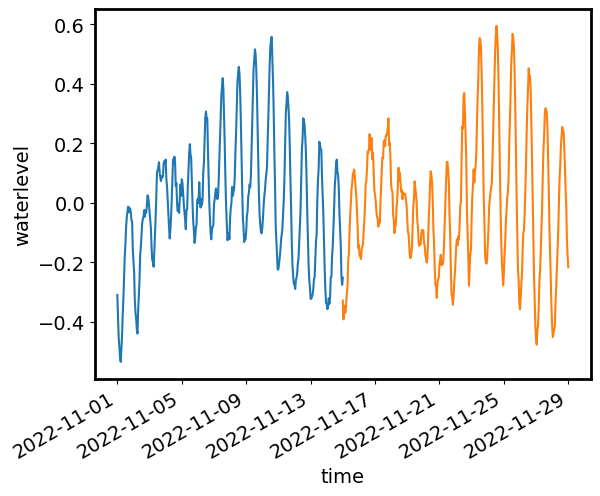

In [102]:
ds_train.plot()
ds_test.plot()

In [103]:
noise = 0.01 # Guess
covparams = params
# covparams = covparams.at[0].set(0.0) # Wipe out mesoscale
meanfunc = harmonic_mean_tmd
meanparams =np.hstack([ha['h_real'].values,ha['h_imag'].values])
nsamples = 200

x = ds_train.time.values
xout = ds_test.time.values
GP = gpjax.GPtideJax(x[:,None], xout[:,None], 
                noise, 
                covfunc_gp,
                covparams,
                mean_func=meanfunc, 
                mean_params=meanparams,
                mean_kwargs=dict(constituents=constituents),
                    )

y_pred = GP(ds_train.values[:,None])#-GP.mu_m
y_cond = GP.conditional(ds_train.values[:,None], samples=nsamples)#-GP.mu_m
y_err = ds_test.values[:,None] - GP.conditional(ds_train.values[:,None], samples=nsamples)#-GP.mu_m

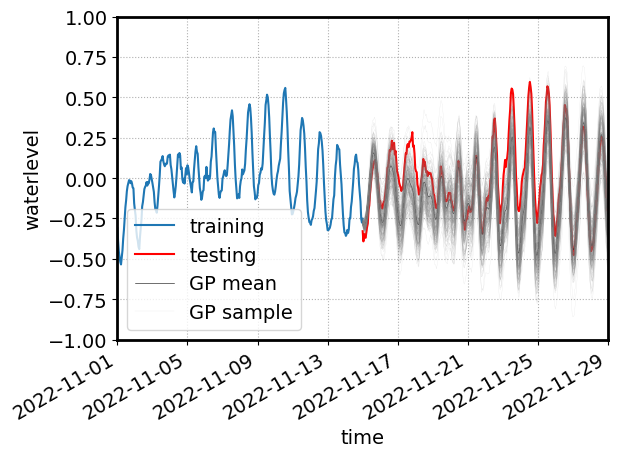

In [104]:
plt.figure()
ds_train.plot()
(ds_test).plot(c='r')
plt.plot(xout, y_pred[:,0], lw=0.4, c='k')

for ii in range(nsamples):
    plt.plot(xout, y_cond[:,ii], lw=0.2, c='0.5', alpha=0.2)

plt.ylim(ylims)
plt.title('')
plt.xlim(ds_train.time[0], ds_test.time[-1])
plt.grid(True, ls=':')
plt.legend(('training','testing','GP mean','GP sample'))
plt.tight_layout()

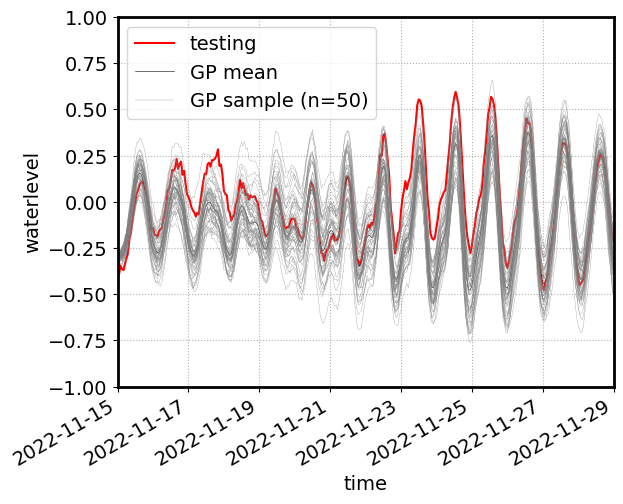

In [105]:
nplot=50
plt.figure()
ds_test.plot(c='r')
# plt.plot(xout, GP.mu_m,'k')
plt.plot(xout, y_pred[:,0], lw=0.4, c='k')

for ii in range(nplot):
    plt.plot(xout, y_cond[:,ii], lw=0.2, c='0.5')
# plt.plot(xout, y_pred[:,0], lw=0.4, c='k')
plt.ylim(ylims)
plt.grid(True, ls=':')
plt.xlim(xout[0], xout[-1])
plt.title('')
plt.legend(('testing','GP mean','GP sample (n={})'.format(nplot)))
# plt.savefig('../FIGURES/{}_2022_v_GP_example_n{}.png'.format(sitename, nplot), dpi=150)

(-1.0, 1.0)

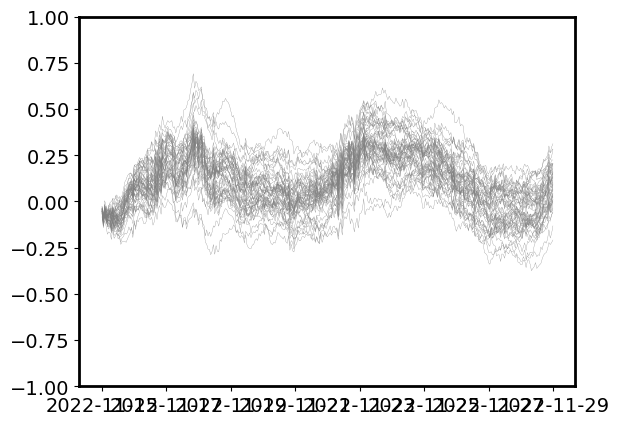

In [106]:
plt.figure()
for ii in range(nplot):
    plt.plot(xout, y_err[:,ii], lw=0.2, c='0.5')
plt.ylim(ylims)

In [107]:
def plot_credint(x, y, clow=5, chigh=95,axis=1, **kwargs):
    y1 = np.percentile(y, clow, axis=axis)
    y2 = np.percentile(y, chigh, axis=axis)
    return plt.fill_between(x, y1, y2, **kwargs)

(array([19311., 19313., 19315., 19317., 19319., 19321., 19323., 19325.]),
 [Text(19311.0, 0, '2022-11-15'),
  Text(19313.0, 0, '2022-11-17'),
  Text(19315.0, 0, '2022-11-19'),
  Text(19317.0, 0, '2022-11-21'),
  Text(19319.0, 0, '2022-11-23'),
  Text(19321.0, 0, '2022-11-25'),
  Text(19323.0, 0, '2022-11-27'),
  Text(19325.0, 0, '2022-11-29')])

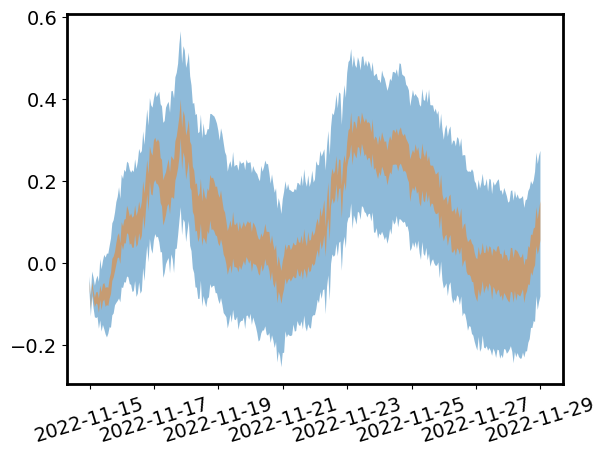

In [108]:
plot_credint(xout, y_err ,alpha=0.5)
plot_credint(xout, y_err, clow=33, chigh=66 ,alpha=0.5)
plt.xticks(rotation=17)

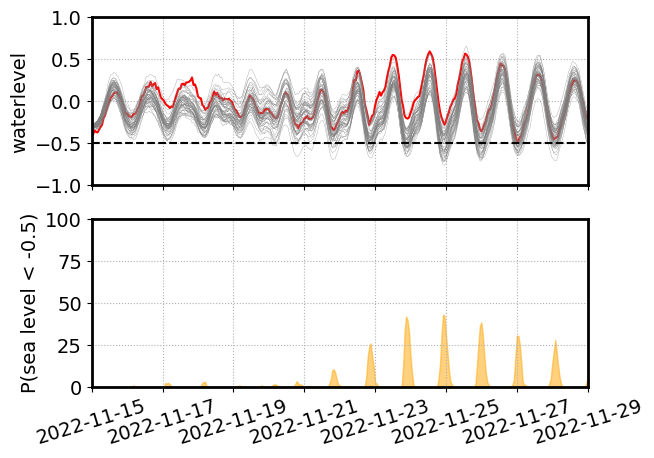

In [109]:
# Simple under keel clearance model
# Probabiltiy of sea level < threshold

threshold = -3.5
threshold = -0.5


N_A_thresh = (y_cond<threshold).sum(axis=1)
P_A_thresh = N_A_thresh/nsamples * 100

plt.figure()
ax=plt.subplot(211)
ds_test.plot(c='r')
for ii in range(nplot):
    plt.plot(xout, y_cond[:,ii], lw=0.2, c='0.5')
# plt.plot(xout, y_pred[:,0], lw=0.4, c='k')
plt.ylim(ylims)
plt.grid(True, ls=':')
plt.xlim(xout[0], xout[-1])
plt.title('')
ax.set_xticklabels([])
ax.set_xlabel('')
plt.hlines( threshold, xout[0], xout[-1], 'k', '--')
# plt.legend(('testing','GP mean','GP sample (n={})'.format(nplot)))

ax=plt.subplot(212)
plt.fill_between(xout, 0, P_A_thresh, color='orange', alpha=0.5)
plt.xticks(rotation=17)
ax.set_ylabel(f'P(sea level < {threshold})')
ax.set_ylim(0,100)
plt.grid(True, ls=':')
plt.xlim(xout[0], xout[-1])

plt.savefig(f'../FIGURES/waterlevel_{site}_P_example.png',dpi=150)